## Import

In [1]:
from mlprimitives.custom.timeseries_preprocessing import time_segments_aggregate
from mlprimitives.custom.timeseries_preprocessing import rolling_window_sequences
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from notebooks.tulog.model import hyperparameters
from orion.primitives.tadgan import TadGAN
from orion.data import load_signal, load_anomalies
from orion import Orion
from notebooks.tulog.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


## Load data

In [2]:
signal = 'nyc_taxi'
df = load_signal(signal)
known_anomalies = load_anomalies(signal)

In [3]:
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


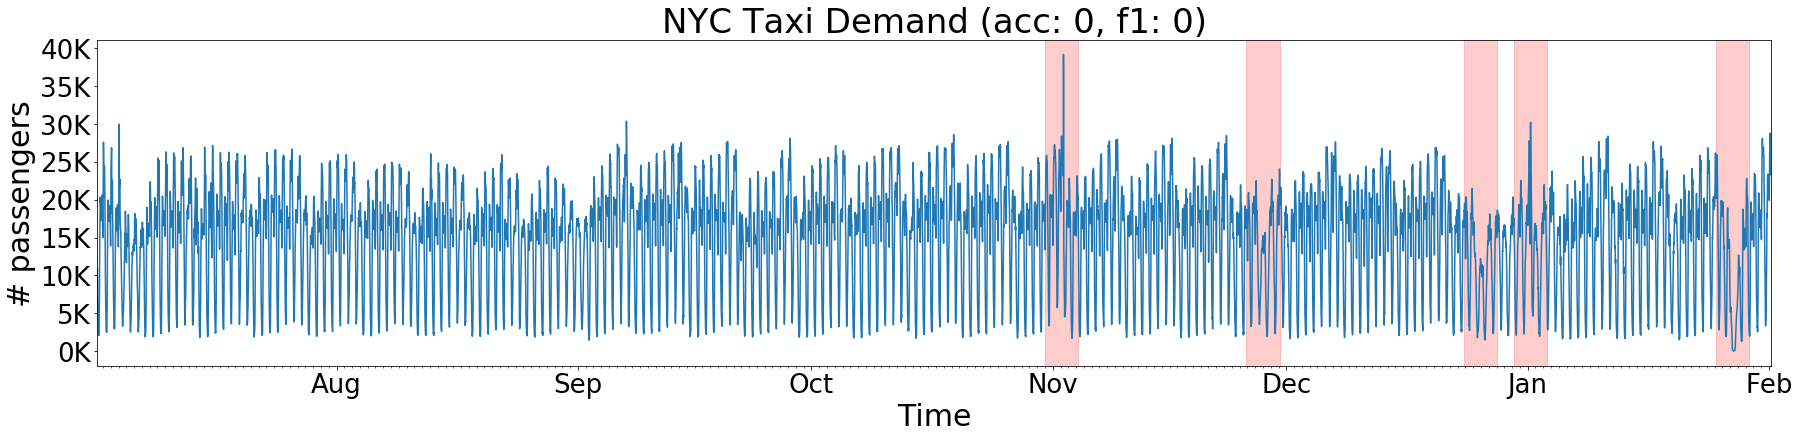

In [4]:
plot(df, known_anomalies)

## Modeling

In [11]:
import os

plt_save_path = os.getcwd() + "//fig_origin//"

if not os.path.isdir(plt_save_path):
    os.mkdir(plt_save_path)

* raw

In [6]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

* imputation

In [7]:
imp = SimpleImputer()
X = imp.fit_transform(X)

* scaling

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

* modeling

In [ ]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

In [ ]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

In [ ]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

In [ ]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
import pandas as pd
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

* iteration

In [10]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

# 0-1 scaling -> change activation function of output layers to sigmoid (default: tanh)
hyperparameters['layers_generator'][7]['parameters']['activation'] = 'sigmoid'

In [13]:
def recons_error_plot(y, y_hat, save_name) :
    # pair-wise error calculation
    error = np.zeros(shape=y.shape)
    length = y.shape[0]
    for i in range(length):
        error[i] = abs(y_hat[i] - y[i])

    # visualize the error curve
    fig = plt.figure(figsize=(30, 3))
    plt.plot(error)
    plt.savefig('{}.png'.format(save_name), dpi=300)
    plt.show()

In [ ]:
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score
from orion.primitives.tadgan import score_anomalies
import pandas as pd

for idx in range(1, 20) :
    tadgan = TadGAN(**hyperparameters)
    tadgan.fit(X)
    # reconstruct
    X_hat, critic = tadgan.predict(X)

    # visualize X_hat
    plot_rws(X_hat, save_opt= True, save_name = plt_save_path+"x_hat_plot_rws_{}".format(idx))
    # flatten the predicted windows
    y_hat = unroll_ts(X_hat)

    # plot the time series
    plot_ts([y, y_hat], labels=['original', 'reconstructed'], save_opt= True, save_name = plt_save_path+"plot_ts_{}".format(idx))
    recons_error_plot(y, y_hat, save_name = plt_save_path+"recons_error_{}".format(idx))

    error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
    pred = np.array(pred).mean(axis=2)

    # visualize the error curve
    plot_error([[true, pred], error], save_opt= True, save_name = plt_save_path+"plot_error_{}".format(idx))

    # threshold
    thresh = 10

    intervals = list()

    i = 0
    max_start = len(error)
    while i < max_start:
        j = i
        start = index[i]
        while error[i] > thresh:
            i += 1

        end = index[i]
        if start != end:
            intervals.append((start, end, np.mean(error[j: i+1])))

        i += 1

    anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
    ground_truth = load_anomalies(signal)
    accuracy = contextual_accuracy(ground_truth, anomalies, start=start, end=end)
    f1_score = contextual_f1_score(ground_truth, anomalies, start=start, end=end)
    plot(df, [anomalies, known_anomalies], save_opt= True, save_name = plt_save_path+"plot_{}".format(idx), acc = accuracy, f1=f1_score)
    anomalies.to_csv(plt_save_path + "anomalies_{}.csv".format(idx), index = False)

* 참고: https://ichi.pro/ko/sigyeyeol-isang-tamji-dib-leoning-sidae-264035144704586